# Simple classification and regression tutorial

In this tutorial we will learn about basic networks used for classification, and regression. 
We will also cover ResNet.

https://www.guru99.com/pytorch-tutorial.html


First load basic modules


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


## Setting up neural networks in pytorch

We can define a class network in pytorch by inheriting `nn.Module`

1. The first part is to define the parameters and layers that you will use
2. The second part is the main task called the forward process that will take an input and predict the output.
3. You can then create an instance of the class using `net = Model()`

In [2]:
class Model(nn.Module):
 def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5)
        self.fc1 = nn.Linear(320, 10)

def forward(self, x):
       x = F.relu(self.conv1(x))
       x = F.relu(self.conv2(x))
       x = x.view(-1, 320)
       x = F.relu(self.fc1(x))
       return F.log_softmax(x)

net = Model()


This network contains 2 convolutional layers, and one fully connected layer.
The first convolution has a kernel of [5x5] takes an 2D image with 3 channels, and outputs 64 channels. 
Once the input goes through 2 passes of convolution and non-linear activation (ReLu), it is reshaped using `x.view(-1, 320)`, and fed into the final FC layer. Before you send the output, you will use the softmax activation function.

The backward process is automatically defined by autograd, so you only need to define the forward process.

### Loss Function
The loss function is used to measure how well the prediction model is able to predict the expected results. PyTorch already has many standard loss functions in the torch.nn module. For example, you can use the Cross-Entropy Loss to solve a multi-class classification problem, or a mean squared error (MSE) loss for regression. 

For example, to define the loss function and compute the losses:

```python
loss_CE = nn.CrossEntropyLoss()
loss_MSE = nn.MSELoss()

#training process
loss = loss_CE(prediction, target)
```

### Optimizer
There are many optmizers available in pytorch - see https://pytorch.org/docs/stable/optim.html for full list and further examples.

You define an optmizer in the following way:

```python
optim = torch.optim.SGD(net.parameters(), lr = 0.01, momentum=0.9)
```


### Backprop and clearing gradients
To perform the backpropagation, you call the loss.backward(), followed by optim.step(). You should clear gradients before every training iteration to esure there's no gradients remaining.

```python
net.zero_grad() # to clear the existing gradient - this should be done prior to a training pass
optim.zero_grad() # to clear gradient in optimizer - this is equivalent to net.zero_grad(). 
loss.backward() # to perform backpropragation - accumulates the gradient (by addition) for each parameter
optim.step() # optimizer.step is performs a parameter update based on the current gradient (stored in .grad attribute of a parameter) and the update rule. 
```

## Simple Regression with PyTorch - Predicting a Simple Function

### Creating a simple neural network

We will now go through an example of how to create, train and test a simple neural network for regression.
We create a simple single layer neural network. It takes an input of size [1] and outputs also size [1].


In [3]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class Net(nn.Module):
   def __init__(self):
       super(Net, self).__init__()
       self.layer = torch.nn.Linear(1, 1)

   def forward(self, x):
       x = self.layer(x)      
       return x

net = Net()
print(net)


Net(
  (layer): Linear(in_features=1, out_features=1, bias=True)
)


### Simulate data using a simple function

We can create simulated data to test our simple regression network. The aim is to use our neural network to estimate/ make predictions. 

We use the following function to randomly generate 100 data points:

$Y = \cos(x) \times x^3 + 4x + 0.6 \times rand()$



In [4]:
# Visualize our data
import matplotlib.pyplot as plt
import numpy as np

x = np.random.rand(100)
y = np.cos(x) * np.power(x,3) + 4*x + np.random.rand(100)*0.6

plt.scatter(x, y)
plt.show()


<Figure size 640x480 with 1 Axes>

Since we're using pytorch, we need to convert our numpy array to a pytorch tensor. The size of the input will be [100, 1], where 100 is the batch size, and 1 is the size of the input (as previously defined in our neural network).

In [5]:
# convert numpy array to tensor in shape of input size
x = torch.from_numpy(x.reshape(-1,1)).float()
y = torch.from_numpy(y.reshape(-1,1)).float()
print(x.size(), y.size())


torch.Size([100, 1]) torch.Size([100, 1])


### Define the optmizer and loss function

We next define our optimizer and loss function. Since we are performing regression, the loss function we chose is Mean Squared Error, or l2 loss. Another common loss function for regression is the Mean Absolute Error, or l1 loss.


In [6]:
# Define Optimizer and Loss Function
#------------------------------------------------------task 1----------------------------------------------------------------
# Task 1: change optimizer here
optimizer = torch.optim.SGD(net.parameters(), lr=0.2)
# Task 1: change loss function here
loss_func = torch.nn.MSELoss()
loss_func = torch.nn.L1Loss()
#----------------------------------------------------------------------------------------------------------------------------


### Training

During training we iterate through our data. Here we use number of epochs = 200, but the optimal number largely depends on the dataset and the task.


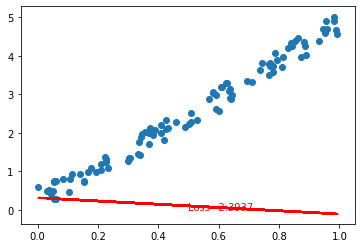

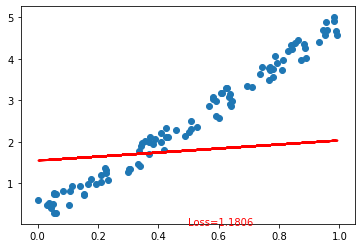

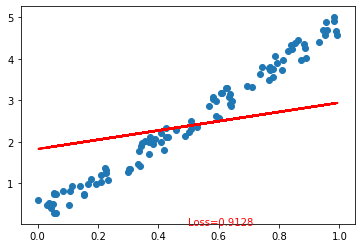

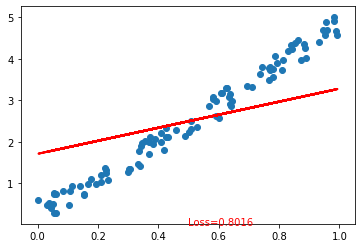

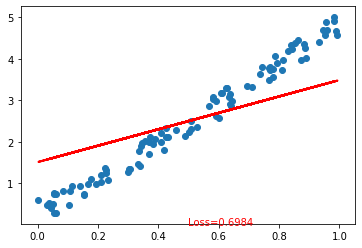

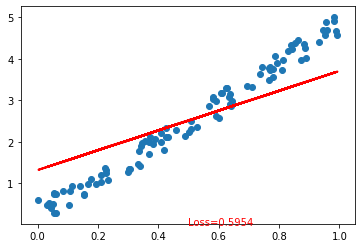

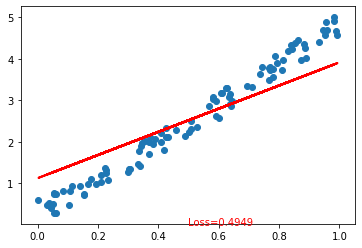

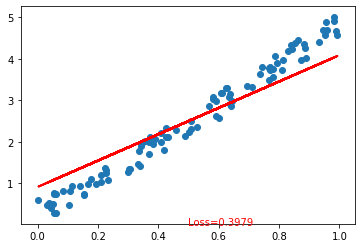

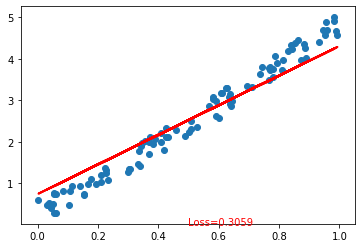

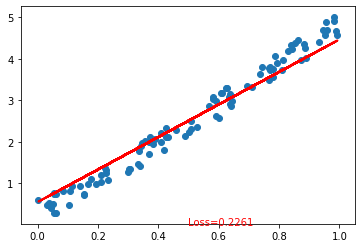

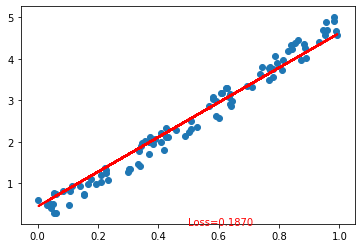

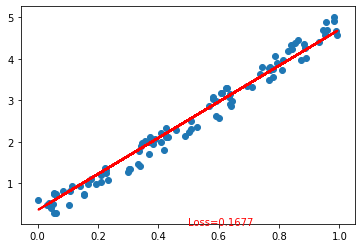

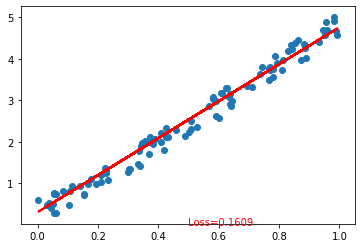

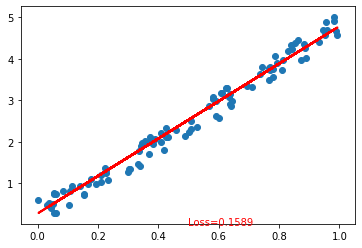

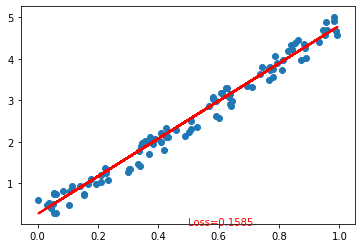

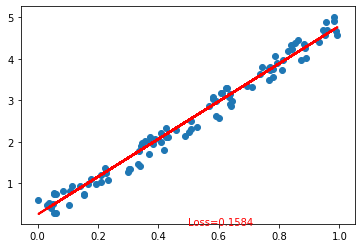

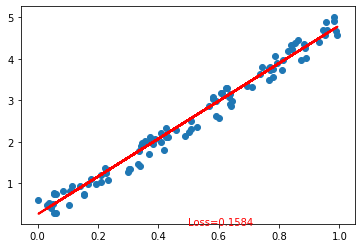

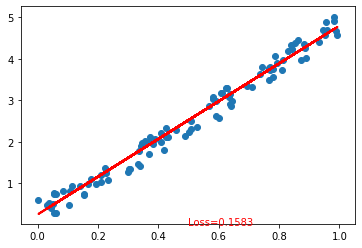

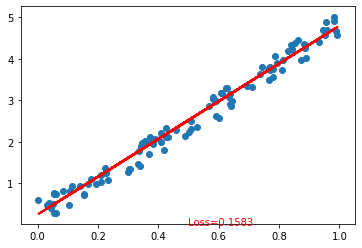

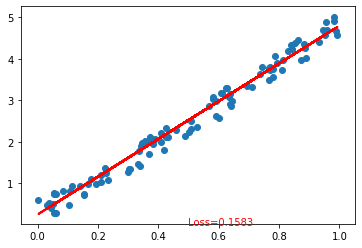

In [7]:
inputs = Variable(x)
outputs = Variable(y)
epochs = 200
for i in range(epochs):
    optimizer.zero_grad() # clear gradients - here we could interchangibly use net.zero_grad()
    prediction = net(inputs) # pass data through network
    loss = loss_func(prediction, outputs) # compute loss  
    loss.backward() # accumulate gradients       
    optimizer.step() # update network parameters

    # Display results
    if i % 10 == 0:
        # note how we need to tranform data back to numpy
        plt.cla()
        plt.scatter(x.data.numpy(), y.data.numpy())
        plt.plot(x.data.numpy(), prediction.data.numpy(), 'r-', lw=2)
        plt.text(0.5, 0, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 10, 'color':  'red'})
        plt.pause(0.1)



### Result

We have now set up and performed simple regression with a neural network. You can see the results above, how in every iteration the red line (the prediction) updates, and moves closer to fit the data.

**You can perform regression with any neural network- the important step to remember is that your final layer should be of output size [1], and the loss function you use is suitable for regression - e.g. mean sqaured error, absolute sqaured error**

### Task 1

1. change the loss function to Mean Absolute Error (l1 loss) - which loss function work better?
2. change the optimiser?

## Image Classification with PyTorch - Handwritten Digit Class Prediction

A very common dataset to learn the basics of deep learning, and even to validate new methods is with the MNIST dataset.
The dataset is a set of 60,000 images of handwritten numbers between 0 - 9, of size [28,28] pixels, with labels.

Here is an example of images from the dataset:

![mnist](mnist.png)



### Loading the data

We again load the data - but this time using Torchvision - a library that comes with pytorch, that helps with dataloading, training and data transforms (e.g. like resizing, or normalizing the image).



In [8]:
import torch
import torchvision
import numpy as np
from torchvision import datasets, models, transforms

# This is used to transform the images to Tensor and normalize it
transform = transforms.Compose(
   [transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])])

training = torchvision.datasets.MNIST(root='./data', train=True,
                                       download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(training, batch_size=8,
                                         shuffle=True, num_workers=2)

testing = torchvision.datasets.MNIST(root='./data', train=False,
                                      download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testing, batch_size=8,
                                        shuffle=False, num_workers=2)

classes = ('0', '1', '2', '3',
          '4', '5', '6', '7', '8', '9')


The transform function converts the images into tensor and normalizes the value. The function torchvision.transforms.MNIST, will download the dataset (if it's not available) in the directory, set the dataset for training if necessary and do the transformation process.

To visualize the dataset, you use the data_iterator to get the next batch of images and labels. You use matplot to plot these images and their appropriate label. As you can see below our images and their labels.

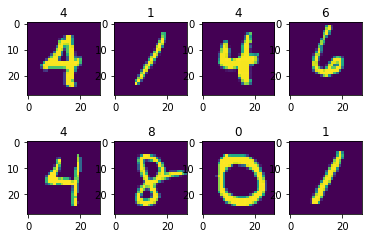

In [9]:
import matplotlib.pyplot as plt
import numpy as np

#create an iterator for train_loader
# get random training images
data_iterator = iter(train_loader)
images, labels = data_iterator.next()

#display 8 images from the dataset
rows = 2
columns = 4
fig=plt.figure()
for i in range(8):
   fig.add_subplot(rows, columns, i+1)
   plt.title(classes[labels[i]])
   img = images[i] / 2 + 0.5 # this is for unnormalize the image
   img = torchvision.transforms.ToPILImage()(img) # tranform tensor to image with torchvision
   plt.imshow(img)
plt.show()


### Create your neural network

We next make a simple neural network for image classification. We create a network with 2 convolutional layers with max pooling and relu non-linearities. The output size = [10], since we have 10 classes, and is followed by a softmax layer to ensure the result is a set of probabilities for each class. Softmax is very commonly used as the last layer in classification tasks.

Note that we also introduce a new way to define a model - using **sequential model**. This is often a **preferred** option if is possible, since it runs faster. 


In [25]:
import torch.nn as nn

# flatten the tensor into 
class Flatten(nn.Module):
   def forward(self, input):
       return input.view(input.size(0), -1)

#sequential based model
seq_model = nn.Sequential(
           nn.Conv2d(1, 10, kernel_size=5),
           nn.MaxPool2d(2),
           nn.ReLU(),
           nn.Dropout2d(),
           nn.Conv2d(10, 20, kernel_size=5),
           nn.MaxPool2d(2),
           nn.ReLU(),
           Flatten(),
           nn.Linear(320, 50),
           nn.ReLU(),
           nn.Linear(50, 10),
           nn.Softmax(),
         )

net = seq_model
print(net)


Sequential(
  (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): Dropout2d(p=0.5, inplace=False)
  (4): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): ReLU()
  (7): Flatten()
  (8): Linear(in_features=320, out_features=50, bias=True)
  (9): ReLU()
  (10): Linear(in_features=50, out_features=10, bias=True)
  (11): Softmax(dim=None)
)


### Loss function and optimizer

We again need to define our loss and optimizers. In this case, since we're doing classification, we use **CrossEntropy Loss**, a commonly used loss function for classification.


In [26]:
import torch.optim as optim

loss_fun = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)



### Training 

We will now train our classifer model - this time iterating 2 times using enumerate. 

### Task 2 

Implement the training interations - see example from regression task

At each epoch, as before we need to clear gradients first (since they are accumalated at each backward step), then we pass the data through the network to make a prediction, compute loss and gradiets, and finally update the parameters.


In [55]:
epochs = 2
for epoch in range(epochs): 

    # enumerate can be used to output iteration index i, as well as the data 
    for i, (data, labels) in enumerate(train_loader, 0):
        # --------------------------------------------------task 2 ------------------------------------------------------------
        # Task 2: implement training iteration here
        # clear the gradient
        optimizer.zero_grad()

        #feed the input and acquire the output from network
        outputs = net(data)

        #calculating the predicted and the expected loss
        loss = loss_fun(outputs, labels)

        #compute the gradient
        loss.backward()

        #update the parameters
        optimizer.step()
        # ---------------------------------------------------------------------------------------------------------------------

        # print statistics
        ce_loss = loss.item()
        if i % 10 == 0:
            print('[%d, %5d] loss: %.3f' %
                 (epoch + 1, i + 1, ce_loss))


[1,     1] loss: 2.304
[1,    11] loss: 2.293
[1,    21] loss: 2.298
[1,    31] loss: 2.293
[1,    41] loss: 2.309
[1,    51] loss: 2.300
[1,    61] loss: 2.298
[1,    71] loss: 2.295
[1,    81] loss: 2.304
[1,    91] loss: 2.309
[1,   101] loss: 2.303
[1,   111] loss: 2.300
[1,   121] loss: 2.303
[1,   131] loss: 2.305
[1,   141] loss: 2.297
[1,   151] loss: 2.298
[1,   161] loss: 2.306
[1,   171] loss: 2.293
[1,   181] loss: 2.299
[1,   191] loss: 2.303
[1,   201] loss: 2.304
[1,   211] loss: 2.296
[1,   221] loss: 2.297
[1,   231] loss: 2.296
[1,   241] loss: 2.289
[1,   251] loss: 2.304
[1,   261] loss: 2.302
[1,   271] loss: 2.300
[1,   281] loss: 2.292
[1,   291] loss: 2.301
[1,   301] loss: 2.298
[1,   311] loss: 2.295
[1,   321] loss: 2.297
[1,   331] loss: 2.297
[1,   341] loss: 2.295
[1,   351] loss: 2.298
[1,   361] loss: 2.294
[1,   371] loss: 2.292
[1,   381] loss: 2.293
[1,   391] loss: 2.301
[1,   401] loss: 2.298
[1,   411] loss: 2.302
[1,   421] loss: 2.294
[1,   431] 

[1,  3561] loss: 1.713
[1,  3571] loss: 1.864
[1,  3581] loss: 1.879
[1,  3591] loss: 1.609
[1,  3601] loss: 1.618
[1,  3611] loss: 1.612
[1,  3621] loss: 2.028
[1,  3631] loss: 1.837
[1,  3641] loss: 1.717
[1,  3651] loss: 1.571
[1,  3661] loss: 1.524
[1,  3671] loss: 1.773
[1,  3681] loss: 1.738
[1,  3691] loss: 1.859
[1,  3701] loss: 1.858
[1,  3711] loss: 1.671
[1,  3721] loss: 1.764
[1,  3731] loss: 1.878
[1,  3741] loss: 1.859
[1,  3751] loss: 1.789
[1,  3761] loss: 1.720
[1,  3771] loss: 1.525
[1,  3781] loss: 1.718
[1,  3791] loss: 1.850
[1,  3801] loss: 1.803
[1,  3811] loss: 1.949
[1,  3821] loss: 1.976
[1,  3831] loss: 1.892
[1,  3841] loss: 1.698
[1,  3851] loss: 1.710
[1,  3861] loss: 1.762
[1,  3871] loss: 2.001
[1,  3881] loss: 2.047
[1,  3891] loss: 1.692
[1,  3901] loss: 1.857
[1,  3911] loss: 1.719
[1,  3921] loss: 1.703
[1,  3931] loss: 1.468
[1,  3941] loss: 1.839
[1,  3951] loss: 1.977
[1,  3961] loss: 1.856
[1,  3971] loss: 1.596
[1,  3981] loss: 1.759
[1,  3991] 

[1,  7121] loss: 1.825
[1,  7131] loss: 1.707
[1,  7141] loss: 1.700
[1,  7151] loss: 1.753
[1,  7161] loss: 1.657
[1,  7171] loss: 1.823
[1,  7181] loss: 1.675
[1,  7191] loss: 1.939
[1,  7201] loss: 1.707
[1,  7211] loss: 1.664
[1,  7221] loss: 1.723
[1,  7231] loss: 1.577
[1,  7241] loss: 1.952
[1,  7251] loss: 1.659
[1,  7261] loss: 1.714
[1,  7271] loss: 1.725
[1,  7281] loss: 1.670
[1,  7291] loss: 1.606
[1,  7301] loss: 1.833
[1,  7311] loss: 1.579
[1,  7321] loss: 1.832
[1,  7331] loss: 1.728
[1,  7341] loss: 1.711
[1,  7351] loss: 1.664
[1,  7361] loss: 1.462
[1,  7371] loss: 1.915
[1,  7381] loss: 1.674
[1,  7391] loss: 1.874
[1,  7401] loss: 1.856
[1,  7411] loss: 1.944
[1,  7421] loss: 1.582
[1,  7431] loss: 1.628
[1,  7441] loss: 1.464
[1,  7451] loss: 1.709
[1,  7461] loss: 1.611
[1,  7471] loss: 1.835
[1,  7481] loss: 1.773
[1,  7491] loss: 1.843
[2,     1] loss: 1.590
[2,    11] loss: 1.831
[2,    21] loss: 1.955
[2,    31] loss: 1.710
[2,    41] loss: 1.461
[2,    51] 

[2,  3181] loss: 1.571
[2,  3191] loss: 1.585
[2,  3201] loss: 1.583
[2,  3211] loss: 1.649
[2,  3221] loss: 1.767
[2,  3231] loss: 1.569
[2,  3241] loss: 1.828
[2,  3251] loss: 1.594
[2,  3261] loss: 1.712
[2,  3271] loss: 2.076
[2,  3281] loss: 1.711
[2,  3291] loss: 1.464
[2,  3301] loss: 1.706
[2,  3311] loss: 1.949
[2,  3321] loss: 1.577
[2,  3331] loss: 1.583
[2,  3341] loss: 1.573
[2,  3351] loss: 1.700
[2,  3361] loss: 1.758
[2,  3371] loss: 2.069
[2,  3381] loss: 2.082
[2,  3391] loss: 1.904
[2,  3401] loss: 1.711
[2,  3411] loss: 1.710
[2,  3421] loss: 1.749
[2,  3431] loss: 1.586
[2,  3441] loss: 2.083
[2,  3451] loss: 1.595
[2,  3461] loss: 1.587
[2,  3471] loss: 1.910
[2,  3481] loss: 1.585
[2,  3491] loss: 1.461
[2,  3501] loss: 1.835
[2,  3511] loss: 1.582
[2,  3521] loss: 1.963
[2,  3531] loss: 1.952
[2,  3541] loss: 1.708
[2,  3551] loss: 1.586
[2,  3561] loss: 1.586
[2,  3571] loss: 1.465
[2,  3581] loss: 1.767
[2,  3591] loss: 1.461
[2,  3601] loss: 1.480
[2,  3611] 

[2,  6741] loss: 2.088
[2,  6751] loss: 1.757
[2,  6761] loss: 2.080
[2,  6771] loss: 1.707
[2,  6781] loss: 1.587
[2,  6791] loss: 1.706
[2,  6801] loss: 1.462
[2,  6811] loss: 1.625
[2,  6821] loss: 1.710
[2,  6831] loss: 1.705
[2,  6841] loss: 1.717
[2,  6851] loss: 1.761
[2,  6861] loss: 1.708
[2,  6871] loss: 1.833
[2,  6881] loss: 1.602
[2,  6891] loss: 1.961
[2,  6901] loss: 1.481
[2,  6911] loss: 1.707
[2,  6921] loss: 1.831
[2,  6931] loss: 1.586
[2,  6941] loss: 1.461
[2,  6951] loss: 1.710
[2,  6961] loss: 1.822
[2,  6971] loss: 1.585
[2,  6981] loss: 1.606
[2,  6991] loss: 1.716
[2,  7001] loss: 1.534
[2,  7011] loss: 1.712
[2,  7021] loss: 1.749
[2,  7031] loss: 1.810
[2,  7041] loss: 1.502
[2,  7051] loss: 1.689
[2,  7061] loss: 1.828
[2,  7071] loss: 1.840
[2,  7081] loss: 1.804
[2,  7091] loss: 1.706
[2,  7101] loss: 1.497
[2,  7111] loss: 1.715
[2,  7121] loss: 1.709
[2,  7131] loss: 1.855
[2,  7141] loss: 1.706
[2,  7151] loss: 1.651
[2,  7161] loss: 1.465
[2,  7171] 

[3,  2801] loss: 1.718
[3,  2811] loss: 1.475
[3,  2821] loss: 1.970
[3,  2831] loss: 1.608
[3,  2841] loss: 1.941
[3,  2851] loss: 1.586
[3,  2861] loss: 1.595
[3,  2871] loss: 1.588
[3,  2881] loss: 1.470
[3,  2891] loss: 1.462
[3,  2901] loss: 1.540
[3,  2911] loss: 1.661
[3,  2921] loss: 1.462
[3,  2931] loss: 1.947
[3,  2941] loss: 1.473
[3,  2951] loss: 1.609
[3,  2961] loss: 1.724
[3,  2971] loss: 1.590
[3,  2981] loss: 1.708
[3,  2991] loss: 1.711
[3,  3001] loss: 1.615
[3,  3011] loss: 1.467
[3,  3021] loss: 1.934
[3,  3031] loss: 1.586
[3,  3041] loss: 1.711
[3,  3051] loss: 1.473
[3,  3061] loss: 1.705
[3,  3071] loss: 1.474
[3,  3081] loss: 1.586
[3,  3091] loss: 1.464
[3,  3101] loss: 1.461
[3,  3111] loss: 1.550
[3,  3121] loss: 1.712
[3,  3131] loss: 1.640
[3,  3141] loss: 1.461
[3,  3151] loss: 1.693
[3,  3161] loss: 1.469
[3,  3171] loss: 1.591
[3,  3181] loss: 1.475
[3,  3191] loss: 1.953
[3,  3201] loss: 1.587
[3,  3211] loss: 1.595
[3,  3221] loss: 1.940
[3,  3231] 

[3,  6361] loss: 1.830
[3,  6371] loss: 1.515
[3,  6381] loss: 1.462
[3,  6391] loss: 1.708
[3,  6401] loss: 1.958
[3,  6411] loss: 1.721
[3,  6421] loss: 1.707
[3,  6431] loss: 1.461
[3,  6441] loss: 1.461
[3,  6451] loss: 1.544
[3,  6461] loss: 1.583
[3,  6471] loss: 1.584
[3,  6481] loss: 1.486
[3,  6491] loss: 1.584
[3,  6501] loss: 1.862
[3,  6511] loss: 1.466
[3,  6521] loss: 1.600
[3,  6531] loss: 1.704
[3,  6541] loss: 1.709
[3,  6551] loss: 1.462
[3,  6561] loss: 1.461
[3,  6571] loss: 1.831
[3,  6581] loss: 1.587
[3,  6591] loss: 1.492
[3,  6601] loss: 1.708
[3,  6611] loss: 1.462
[3,  6621] loss: 1.573
[3,  6631] loss: 1.470
[3,  6641] loss: 1.461
[3,  6651] loss: 1.462
[3,  6661] loss: 1.708
[3,  6671] loss: 1.589
[3,  6681] loss: 1.663
[3,  6691] loss: 1.586
[3,  6701] loss: 1.586
[3,  6711] loss: 1.462
[3,  6721] loss: 1.712
[3,  6731] loss: 1.461
[3,  6741] loss: 1.654
[3,  6751] loss: 1.530
[3,  6761] loss: 1.685
[3,  6771] loss: 1.475
[3,  6781] loss: 1.587
[3,  6791] 

[4,  2421] loss: 1.462
[4,  2431] loss: 1.464
[4,  2441] loss: 1.637
[4,  2451] loss: 1.461
[4,  2461] loss: 1.475
[4,  2471] loss: 1.723
[4,  2481] loss: 1.594
[4,  2491] loss: 1.629
[4,  2501] loss: 1.589
[4,  2511] loss: 1.461
[4,  2521] loss: 1.702
[4,  2531] loss: 1.712
[4,  2541] loss: 1.468
[4,  2551] loss: 1.703
[4,  2561] loss: 1.593
[4,  2571] loss: 1.622
[4,  2581] loss: 1.695
[4,  2591] loss: 1.520
[4,  2601] loss: 1.463
[4,  2611] loss: 1.590
[4,  2621] loss: 1.585
[4,  2631] loss: 1.597
[4,  2641] loss: 1.497
[4,  2651] loss: 1.562
[4,  2661] loss: 1.593
[4,  2671] loss: 1.827
[4,  2681] loss: 1.586
[4,  2691] loss: 1.628
[4,  2701] loss: 1.591
[4,  2711] loss: 1.461
[4,  2721] loss: 1.583
[4,  2731] loss: 1.698
[4,  2741] loss: 1.585
[4,  2751] loss: 1.586
[4,  2761] loss: 1.708
[4,  2771] loss: 1.462
[4,  2781] loss: 1.561
[4,  2791] loss: 1.587
[4,  2801] loss: 1.711
[4,  2811] loss: 1.588
[4,  2821] loss: 1.461
[4,  2831] loss: 1.588
[4,  2841] loss: 1.531
[4,  2851] 

[4,  5981] loss: 1.461
[4,  5991] loss: 1.461
[4,  6001] loss: 1.593
[4,  6011] loss: 1.586
[4,  6021] loss: 1.585
[4,  6031] loss: 1.711
[4,  6041] loss: 1.588
[4,  6051] loss: 1.699
[4,  6061] loss: 1.586
[4,  6071] loss: 1.583
[4,  6081] loss: 1.464
[4,  6091] loss: 1.464
[4,  6101] loss: 1.586
[4,  6111] loss: 1.586
[4,  6121] loss: 1.462
[4,  6131] loss: 1.586
[4,  6141] loss: 1.461
[4,  6151] loss: 1.703
[4,  6161] loss: 1.600
[4,  6171] loss: 1.586
[4,  6181] loss: 1.588
[4,  6191] loss: 1.706
[4,  6201] loss: 1.586
[4,  6211] loss: 1.709
[4,  6221] loss: 1.498
[4,  6231] loss: 1.813
[4,  6241] loss: 1.708
[4,  6251] loss: 1.818
[4,  6261] loss: 1.462
[4,  6271] loss: 1.588
[4,  6281] loss: 1.586
[4,  6291] loss: 1.837
[4,  6301] loss: 1.584
[4,  6311] loss: 1.461
[4,  6321] loss: 1.799
[4,  6331] loss: 1.842
[4,  6341] loss: 1.706
[4,  6351] loss: 1.462
[4,  6361] loss: 1.588
[4,  6371] loss: 1.462
[4,  6381] loss: 1.598
[4,  6391] loss: 1.758
[4,  6401] loss: 1.687
[4,  6411] 

[5,  2041] loss: 1.611
[5,  2051] loss: 1.659
[5,  2061] loss: 1.835
[5,  2071] loss: 1.484
[5,  2081] loss: 1.588
[5,  2091] loss: 1.586
[5,  2101] loss: 1.586
[5,  2111] loss: 1.587
[5,  2121] loss: 1.461
[5,  2131] loss: 1.461
[5,  2141] loss: 1.582
[5,  2151] loss: 1.461
[5,  2161] loss: 1.709
[5,  2171] loss: 1.582
[5,  2181] loss: 1.564
[5,  2191] loss: 1.709
[5,  2201] loss: 1.466
[5,  2211] loss: 1.709
[5,  2221] loss: 1.462
[5,  2231] loss: 1.461
[5,  2241] loss: 1.654
[5,  2251] loss: 1.653
[5,  2261] loss: 1.585
[5,  2271] loss: 1.838
[5,  2281] loss: 1.584
[5,  2291] loss: 1.586
[5,  2301] loss: 1.719
[5,  2311] loss: 1.465
[5,  2321] loss: 1.586
[5,  2331] loss: 1.711
[5,  2341] loss: 1.586
[5,  2351] loss: 1.708
[5,  2361] loss: 1.830
[5,  2371] loss: 1.590
[5,  2381] loss: 1.641
[5,  2391] loss: 1.653
[5,  2401] loss: 1.608
[5,  2411] loss: 1.494
[5,  2421] loss: 1.586
[5,  2431] loss: 1.465
[5,  2441] loss: 1.707
[5,  2451] loss: 1.472
[5,  2461] loss: 1.478
[5,  2471] 

[5,  5601] loss: 1.465
[5,  5611] loss: 1.586
[5,  5621] loss: 1.709
[5,  5631] loss: 1.809
[5,  5641] loss: 1.706
[5,  5651] loss: 1.461
[5,  5661] loss: 1.583
[5,  5671] loss: 1.588
[5,  5681] loss: 1.583
[5,  5691] loss: 1.491
[5,  5701] loss: 1.481
[5,  5711] loss: 1.586
[5,  5721] loss: 1.461
[5,  5731] loss: 1.670
[5,  5741] loss: 1.583
[5,  5751] loss: 1.711
[5,  5761] loss: 1.585
[5,  5771] loss: 1.601
[5,  5781] loss: 1.585
[5,  5791] loss: 1.712
[5,  5801] loss: 1.709
[5,  5811] loss: 1.710
[5,  5821] loss: 1.462
[5,  5831] loss: 1.461
[5,  5841] loss: 1.935
[5,  5851] loss: 1.586
[5,  5861] loss: 1.461
[5,  5871] loss: 1.461
[5,  5881] loss: 1.599
[5,  5891] loss: 1.586
[5,  5901] loss: 1.605
[5,  5911] loss: 1.461
[5,  5921] loss: 1.473
[5,  5931] loss: 1.641
[5,  5941] loss: 1.470
[5,  5951] loss: 1.467
[5,  5961] loss: 1.461
[5,  5971] loss: 1.626
[5,  5981] loss: 1.461
[5,  5991] loss: 1.487
[5,  6001] loss: 1.704
[5,  6011] loss: 1.605
[5,  6021] loss: 1.588
[5,  6031] 

### Testing

We now used our trained network to make a prediction on our test set. 


In [56]:
#make an iterator from test_loader
test_iterator = iter(test_loader)
#Get a batch of testing images
images, labels = test_iterator.next()


Predicted:      7     2     1     0     4     1     4     9


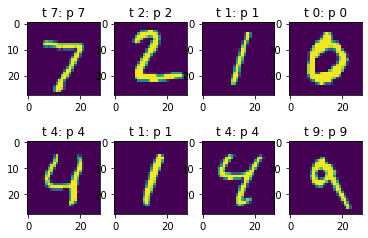

In [57]:
results = net(images)
# get predicted class from the class probabilities
_, predicted = torch.max(results, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(8)))

# plot results - true label (t) vs predicted label (p)
fig2 = plt.figure()
for i in range(8):
    fig2.add_subplot(rows, columns, i+1)
    plt.title('t ' + classes[labels[i]] + ': p ' + classes[predicted[i]])
    img = images[i] / 2 + 0.5     # this is to unnormalize the image
    img = torchvision.transforms.ToPILImage()(img)
    plt.imshow(img)
plt.show()


### Computing classification scores

We will now use the predictions to compute the accuracy, f1 score, precision and recall. These are scores commonly used to evaluate classification, in particular the f1 score is a good measure for datasets with imbalanced classes.

In [58]:
labels = labels.data.numpy()
predicted = predicted.data.numpy()


In [59]:
# first convert labels and predictions to one hot vectors
labels_v = np.zeros((labels.shape[0], 10))
predicted_v = np.zeros((predicted.shape[0], 10))

for i in np.arange(labels.shape[0]):
    labels_v[i,labels[i]] = 1 
    predicted_v[i,predicted[i]] = 1 

In [60]:
# classifcation scores

# True positive
tp = np.sum(labels_v * predicted_v)
# False positive
fp = np.sum((labels_v == 0) * predicted_v)
# True negative
tn = np.sum((labels_v == 0) * (predicted_v == 0))
# False negative
fn = np.sum(labels_v * (predicted_v == 0))

# True positive rate (sensitivity or recall)
tpr = tp / (tp + fn)
# False positive rate (fall-out)
fpr = fp / (fp + tn)
# Precision
precision = tp / (tp + fp)
# True negatvie tate (specificity)
tnr = 1 - fpr
# F1 score - precision-recall score
f1 = 2 * tp / (2 * tp + fp + fn)
# accuracy
accuracy = (tp + tn) / (tp + tn + fp + fn)

print('accuracy:', accuracy, 'f1 score:', f1, 'precision:', precision, 'recall:', tpr)

accuracy: 1.0 f1 score: 1.0 precision: 1.0 recall: 1.0


## ResNet with pytorch



One of the problems ResNets solve is the famous known vanishing gradient. This is because when the network is too deep, the gradients from where the loss function is calculated easily shrink to zero after several applications of the chain rule. This result on the weights never updating its values and therefore, no learning is being performed.
With ResNets, the gradients can flow directly through the skip connections backwards from later layers to initial filters.


![resnet-block](resnet-block.png)
source: https://d2l.ai/chapter_convolutional-modern/resnet.html

http://www.pabloruizruiz10.com/resources/CNNs/ResNet-PyTorch.html

https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8


### Using existing ResNet 
PyTorch provides torchvision.models, which include multiple deep learning models, pre-trained on the ImageNet dataset and ready to use.

Pre-training lets you leverage transfer learning – once the model has learned many objects, features, and textures on the huge ImageNet dataset, you can apply this learning to your own images and recognition problems.

torchvision.models include the following ResNet implementations: ResNet-18, 34, 50, 101 and 152 (the numbers indicate the numbers of layers in the model), and Densenet-121, 161, 169, and 201.

The following classes allow you to access ResNet models in PyTorch:
```python
torchvision.models.resnet18(pretrained=False, **kwargs)
torchvision.models.resnet34(pretrained=False, **kwargs)
torchvision.models.resnet50(pretrained=False, **kwargs)
torchvision.models.resnet101(pretrained=False, **kwargs)
torchvision.models.resnet152(pretrained=False, **kwargs)
```

### Create custom ResNet layers 

If you want to create a different ResNet architecture than the ones built into PyTorch, you can create your own custom implementation of ResNet.

Here we have a Basic ResNet block (see image above).

### Task 3 - implement the forward pass of the BasicBlock

To implement a ResNet basic block you need to have the following steps:
1. Convolution, followed by batchnorm, followed by relu
2. Convolution, followed by batchnorm 
3. shortcut step, added to the output of the convolutions
4. relu


In [21]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        #-----------------------------------------------------task 3 -----------------------------------------------------
        # Task 3: implement a forward pass
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        #-----------------------------------------------------------------------------------------------------------------
        return out


In [26]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])


## Use ResNet for classification

### Task 4 - run ResNet on MNIST for classification
Create a ResNet network and run with the same code as above for classification, and then test.
Remember to define your loss function, optimizer, dataloaders, and your resnet network. 
Then run the training and testing, as before.



In [ ]:
#-----------------------------------------------------task 4 -----------------------------------------------------
# Task 4: Train and test ResNet on MNIST dataset for classification

# ----------------------------------------------------------------------------------------------------------------

In [27]:
import torch.optim as optim

loss_fun = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

resnet = ResNet18()

In [ ]:
epochs = 2
for epoch in range(epochs): 

    # enumerate can be used to output iteration index i, as well as the data 
    for i, (data, labels) in enumerate(train_loader, 0):
        # clear the gradient
        optimizer.zero_grad()

        #feed the input and acquire the output from network
        outputs = resnet(data)

        #calculating the predicted and the expected loss
        loss = loss_fun(outputs, labels)

        #compute the gradient
        loss.backward()

        #update the parameters
        optimizer.step()

        # print statistics
        ce_loss = loss.item()
        if i % 10 == 0:
            print('[%d, %5d] loss: %.3f' %
                 (epoch + 1, i + 1, ce_loss))


[1,     1] loss: 2.010
[1,    11] loss: 2.451
[1,    21] loss: 2.405
[1,    31] loss: 2.471
[1,    41] loss: 2.375
[1,    51] loss: 2.500
[1,    61] loss: 2.304
[1,    71] loss: 2.287
[1,    81] loss: 2.511
[1,    91] loss: 2.623
[1,   101] loss: 2.328
[1,   111] loss: 2.368
[1,   121] loss: 2.590
[1,   131] loss: 2.551
[1,   141] loss: 2.536
[1,   151] loss: 2.353
[1,   161] loss: 2.174
[1,   171] loss: 2.498
[1,   181] loss: 2.421
[1,   191] loss: 2.408
[1,   201] loss: 2.389
[1,   211] loss: 2.291
[1,   221] loss: 2.334
[1,   231] loss: 2.350
[1,   241] loss: 2.602
[1,   251] loss: 2.384
[1,   261] loss: 2.533
[1,   271] loss: 2.355
[1,   281] loss: 2.413
[1,   291] loss: 2.551
[1,   301] loss: 2.588
[1,   311] loss: 2.406
[1,   321] loss: 2.233
[1,   331] loss: 2.331
[1,   341] loss: 2.313
[1,   351] loss: 2.642
[1,   361] loss: 2.576
[1,   371] loss: 2.196
[1,   381] loss: 2.261
[1,   391] loss: 2.411
[1,   401] loss: 2.524
[1,   411] loss: 2.459
[1,   421] loss: 2.286
[1,   431] 

[1,  3561] loss: 2.409
[1,  3571] loss: 2.613
[1,  3581] loss: 2.285
[1,  3591] loss: 2.419
[1,  3601] loss: 2.322
[1,  3611] loss: 2.698
[1,  3621] loss: 2.283
[1,  3631] loss: 2.463
[1,  3641] loss: 2.138
[1,  3651] loss: 2.546
[1,  3661] loss: 2.491
[1,  3671] loss: 2.386
[1,  3681] loss: 2.244
[1,  3691] loss: 2.443
[1,  3701] loss: 2.324
[1,  3711] loss: 2.631
[1,  3721] loss: 2.347
[1,  3731] loss: 2.172
[1,  3741] loss: 2.577
[1,  3751] loss: 2.631
[1,  3761] loss: 2.180
[1,  3771] loss: 2.140
[1,  3781] loss: 2.524
[1,  3791] loss: 2.408
[1,  3801] loss: 2.336
[1,  3811] loss: 2.274
[1,  3821] loss: 2.483
[1,  3831] loss: 2.420
[1,  3841] loss: 2.330
[1,  3851] loss: 2.539
[1,  3861] loss: 2.315
[1,  3871] loss: 2.393
[1,  3881] loss: 2.363
[1,  3891] loss: 2.221
[1,  3901] loss: 2.533
[1,  3911] loss: 2.520
[1,  3921] loss: 2.395
[1,  3931] loss: 2.460
[1,  3941] loss: 2.540
[1,  3951] loss: 2.177
[1,  3961] loss: 2.073
[1,  3971] loss: 2.195
[1,  3981] loss: 2.396
[1,  3991] 

Predicted:      5     5     2     5     5     5     5     5


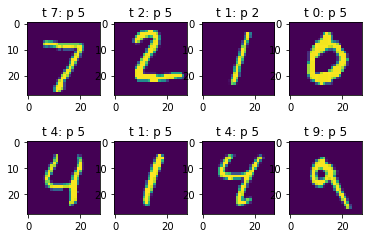

In [32]:
#make an iterator from test_loader
#Get a batch of testing images
test_iterator = iter(test_loader)
images, labels = test_iterator.next()

results = resnet(images)
# get predicted class from the class probabilities
_, predicted = torch.max(results, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(8)))

# plot results - true label (t) vs predicted label (p)
fig2 = plt.figure()
for i in range(8):
    fig2.add_subplot(rows, columns, i+1)
    plt.title('t ' + classes[labels[i]] + ': p ' + classes[predicted[i]])
    img = images[i] / 2 + 0.5     # this is to unnormalize the image
    img = torchvision.transforms.ToPILImage()(img)
    plt.imshow(img)
plt.show()
